# **Natural Language Processing: Autocompletion**
PALS0039 Introduction to Deep Learning for Speech and Language Processing

Candidate Number: YWKF8

Date: 24th April, 2023

##**Part A. Background Information**
Autocompletion involved the process of predicting the next words and letters. We encounter autocompletion in many scenarios, such as when typing our questions in Google.

Early efforts in autocompletion relied on n-gram models, which predict the next word based on the preceding n-1 words (Chen & Goodman, 1999). This approach was simple but faced many limitations due to the data sparsity problem.

Later studies tended to use Recurrent Neural Networks (RNNs) for the next word and next letter prediction. RNNs have an internal state that can store information from previous time steps. Therefore, they are ideal for handling sequential data (Medsker & Jain, 2001). Among these studies, many applied Long Short-Term Memory (LSTM) networks (e.g., Gana & Khursheed, 2019) because, compared to normal RNNs, LSTMs have a more complex cell structure, which allows them to better capture long-term context information (Hochreiter & Schmidhuber, 1997). Thus, LSTMs can be effective for next-word prediction tasks.

However, many studies focused on predicting a single word or letter, and only a few studies attempted to predict multiple words and letters. The present work aims to create two multi-output models using LSTMs. One can predict the **next two words** in sequence, and the other should predict the **next two letters** in sequence. Both of them should predict based on the sentences or words provided. These two tasks involve training models for learning the patterns and dependencies in the training text and then generating accurate and, ideally, contextually relevant predictions. Present work will demonstrate this process step by step, including data preparation, model construction, model training, and the evaluation of results.



## **Part B. Method**

In [ ]:
# Libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, get_file
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

### **Step 1: Data Preperation**

This work used the text of 'Pride and Prejudice' found on Gutenberg.org. You may access the full text via: https://www.gutenberg.org/cache/epub/1342/pg1342.txt

####**1.1 Data Cleaning**

In [ ]:
# First, load the text data
path = get_file('Pride and Prejudice.txt', 
                origin='https://www.gutenberg.org/cache/epub/1342/pg1342.txt')
text = open(path).read().lower()  # read the file and make letters lowercases

# Second, replace code-like texts and others
text = text.replace('\n', ' ').replace('\r', ' ').replace('\ufeff', ' ').replace('--', ' ')

# Third, we filtered out all symbols, and only saved letters and spaces
regex = re.compile('[^a-z ]')     # from re package, this include 26 letters and space
text = regex.sub('', text)        # the first parameter is the replacement, the second is input string

# Next, split the data by space so the words are isolated
text_all = text.split(' ')

# Finally, remove extra spaces and none
text_pure = []
for each in text_all:
  if each != ' ' and each != '':
    text_pure.append(each)

In [ ]:
print('Randomly print 3 segments to check the raw data:')
print(text_pure[900:920])
print(text_pure[1900:1920])
print(text_pure[11900:11920])

Randomly print 3 segments to check the raw data:
['feature', 'of', 'that', 'otherwise', 'admirable', 'book', 'although', 'miss', 'austen', 'always', 'liked', 'something', 'of', 'the', 'misunderstanding', 'kind', 'which', 'afforded', 'her', 'opportunities']
['memling', 'at', 'one', 'end', 'of', 'the', 'history', 'of', 'painting', 'and', 'meissonier', 'at', 'the', 'other', 'than', 'of', 'cosway', 'or', 'any', 'of']
['instrument', 'by', 'her', 'sister', 'mary', 'who', 'having', 'in', 'consequence', 'of', 'being', 'the', 'only', 'plain', 'one', 'in', 'the', 'family', 'worked', 'hard']


Next, we need to customise the data for word and character levels. Noticing that present work only trained one-quarter of the full text to reduce the training time.

For the **word level**, we need to break the full text into many strings (chunks), with each string containing some words. Here, I made each chunk to include 20 words.

In [ ]:
# Word level
# Adjust the chunk length to 20
chunk_len = 20
word_chunk = []
for i in range(0, len(text_pure), chunk_len):
    chunk = ' '.join(text_pure[i:i + chunk_len])              # join 20 words together
    word_chunk.append(chunk)

# Get one quater of the full text
word_all = word_chunk[len(word_chunk)//4:len(word_chunk)//2]  # use data from 0.25 to 0.5 segments of the full text

In [ ]:
print('Check the data for word level:')
print(word_all[:2])

Check the data for word level:
['oddities of her cousin and to point him out to her particular notice the two first dances however brought a', 'return of distress they were dances of mortification mr collins awkward and solemn apologizing instead of attending and often moving']


For **character level**, we can either put several words into a chunk or let the computer learn every single word. I chose the latter so I did not make further changes.

In [ ]:
# Character level
# Get one quater of the full text
character_all = text_pure[len(text_pure)//4:len(text_pure)//2]

In [ ]:
print('Check the data for character level:')
print(character_all[:20])

Check the data for character level:
['to', 'point', 'him', 'out', 'to', 'her', 'particular', 'notice', 'the', 'two', 'first', 'dances', 'however', 'brought', 'a', 'return', 'of', 'distress', 'they', 'were']


####**1.2 Spliting Training and Testing sets**

The proportion of training and testing sets is 8:2.

In [ ]:
# Word level
splitpoint_word = int(len(word_all)*0.8)
# word training set
word_train = word_all[:splitpoint_word]
# word test set
word_test = word_all[splitpoint_word:]

In [ ]:
# Character level
splitpoint_char = int(len(character_all)*0.8)
# letter training set
char_train = character_all[:splitpoint_char]
# letter test set
char_test = character_all[splitpoint_char:]

####**1.3 Tokenisation**

Letters and words cannot be understood by the computer. Thus, we need to turn them into numerical representations that computers can understand. Tokenisation allows each word/letter to have a unique numerical representation. Here, I use the function Tokenizer() from the Keras package.


In [ ]:
# Define a function to get sequences of data
'''
I wrote this function with three parameters:
1. level: Defining the level. Passing 'word' or 'character'
2. data: Passing the data (a list)
3. trainTokeniser: Default is None, meaning no tokeniser. If passing a specified
tokeniser the data will use that one to get sequences. This help match the 
sequence in training and test set.
The list comprehension below means that if there is no tokeniser, create a new
one. If there is a tokeniser, use the tokeniser passed to the function.
'''

def get_sequence(level, data, trainTokeniser=None):
    if level == 'word':
        tokeniser = Tokenizer(oov_token='<OOV>') if trainTokeniser is None else trainTokeniser
    elif level == 'character':
        tokeniser = Tokenizer(char_level=True) if trainTokeniser is None else trainTokeniser
    if trainTokeniser is None:
        tokeniser.fit_on_texts(data)
    sequence = tokeniser.texts_to_sequences(data)
    size = len(tokeniser.word_index) + 1  # Plus 1 reserving place for padding

    return sequence, size, tokeniser

In [ ]:
# Word level
sequence_word_train, train_vocab_size, tokenizer_word = get_sequence('word', word_train)
sequence_word_test, test_vocab_size, _ = get_sequence('word', word_test, trainTokeniser=tokenizer_word)

print('Check training data sequence:')
print(word_train[:2])
print(sequence_word_train[:2])
print('The training vocabulary size is: ' + str(train_vocab_size))
print('----------------------------------')
print('Check test data sequence:')
print(word_test[:2])
print(sequence_word_test[:2])
print('The test vocabulary size is: ' + str(test_vocab_size))

Check training data sequence:
['oddities of her cousin and to point him out to her particular notice the two first dances however brought a', 'return of distress they were dances of mortification mr collins awkward and solemn apologizing instead of attending and often moving']
[[1665, 4, 6, 203, 5, 3, 222, 31, 89, 3, 6, 529, 407, 2, 127, 121, 605, 116, 462, 9], [211, 4, 704, 38, 34, 605, 4, 1147, 22, 46, 865, 5, 866, 1148, 530, 4, 867, 5, 147, 1666]]
The training vocabulary size is: 3154
----------------------------------
Check test data sequence:
['fitzwilliam had called at the parsonage more than once during the time but mr darcy they had only seen at', 'church the invitation was accepted of course and at a proper hour they joined the party in lady catherines drawingroom']
[[856, 23, 450, 29, 2, 702, 66, 62, 380, 504, 2, 80, 25, 22, 76, 38, 23, 106, 214, 29], [857, 2, 319, 12, 464, 4, 449, 5, 29, 9, 493, 711, 38, 434, 2, 244, 7, 64, 563, 860]]
The test vocabulary size is: 3154


Now each number represents a specific word. Because test set data adopted the tokeniser from training data, they should have the same representations. 

Character level tokenisation follows the same process, but each letter is transferred into a number rather than each word. See below:

In [ ]:
# Character level
sequence_char_train, train_letter_size, tokenizer_char = get_sequence('character', char_train)
sequence_char_test, test_letter_size, _ = get_sequence('word', char_test, trainTokeniser=tokenizer_char)

print('Check the training data sequence:')
print(char_train[:5])
print(sequence_char_train[:5])
print('The training letter size is: ' + str(train_letter_size))
print('----------------------------------')
print('Check the test data sequence:')
print(char_test[:5])
print(sequence_char_test[:5])
print('The test letter size is: ' + str(test_letter_size))

Check the training data sequence:
['to', 'point', 'him', 'out', 'to']
[[2, 4], [20, 4, 6, 5, 2], [8, 6, 13], [4, 12, 2], [2, 4]]
The training letter size is: 27
----------------------------------
Check the test data sequence:
['parsonage', 'more', 'than', 'once', 'during']
[[20, 3, 9, 7, 4, 5, 3, 18, 1], [13, 4, 9, 1], [2, 8, 3, 5], [4, 5, 14, 1], [11, 12, 9, 6, 5, 18]]
The test letter size is: 27


####**1.4 Setting input (X) and output (y)**

This is a very important step as it determines how the computer will learn the pattern.

We can first think of how to predict the next word in each sentence. The basic logic is that for each sentence, we set the last word as the output and the words before as the input. Therefore, for predicting two words, we can make the last two words of each sentence the output. See Table 1 below.

**Table 1.** 

*An example of simple input and output structure.*

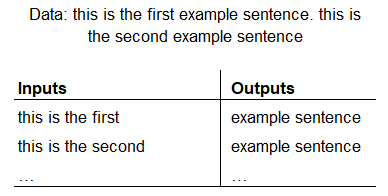

However, this can be inefficient and it does not fully utilise the data. Additionally, making two words as one output may result in the predicted two words not being in sequence. To fix these problems, I set the input and output structure as shown in Table 2.

**Table 2.** 

*An example of refined input and output structure.*

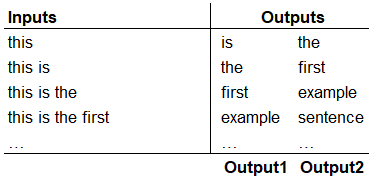

In this structure, each sentence is broken down into many different inputs and outputs which are in sequence. I also set two outputs, y1 and y2, which emphasises the sequence of two words.

In [ ]:
# Define a function of creating one input and two outputs
def creat_xy(sequence, level):
    X, y, y1, y2 = [], [], [], []              # create lists for input and outputs
    dropped = 0                                # this is to record the number of sentences/words being dropped.
    for each in sequence:
        if len(each) > 2:                      # final training set will only contain sentences/words having 3+ words/letters
            for index in range(2, len(each)):  # this loop cuts the sentence into the structure shown in Table 2
                xy_splitpoint = index - 1      # the last 2 words are always outputs, and everything before is input
                X.append(each[:xy_splitpoint])
                y.append(each[xy_splitpoint:index + 1])
        else:
            dropped += 1

    # Pad input to the same length
    X = pad_sequences(X) 
    # Separate the one output into two
    for pair in y:
        y1.append(pair[0])
        y2.append(pair[1])
    
    # Convert outputs into binary matrix
    '''
    This step is required because later we will use loss function as categorical
    cross entropy. It requires integer value to be converted into binary matric 
    representation.
    '''
    if level == 'word':
        y1 = to_categorical(y1, num_classes=train_vocab_size)
        y2 = to_categorical(y2, num_classes=train_vocab_size)  # passing same num_classes ensures dimensions are the same
    elif level == 'character':
        y1 = to_categorical(y1, num_classes=train_letter_size)
        y2 = to_categorical(y2, num_classes=train_letter_size)

    return X, y1, y2, dropped

In [ ]:
# Word level
Xtrain, ytrain_word1, ytrain_word2, word_drop_train = creat_xy(sequence_word_train, 'word')
Xtest_word, ytest_word1, ytest_word2, word_drop_test = creat_xy(sequence_word_test, 'word')

# Check data
print('Word Level')
print('Check if sentences are dropped:')
print('In training set, ' + str(word_drop_train) + ' sentences are dropped')
print('In test set, ' + str(word_drop_test) + ' sentences are dropped')
print('-------------------------------------')
print('Check the shape of input and output:')
print('Xtrain: ' + str(Xtrain.shape) + '    ' + 
      'ytrain word1: ' + str(ytrain_word1.shape) + '    ' +
      'ytrain word2: ' + str(ytrain_word2.shape))
print('Xtest: ' + str(Xtest_word.shape) + '    ' + 
      'ytest word1: ' + str(ytest_word1.shape) + '    ' + 
      'ytest word2: ' + str(ytest_word2.shape))

Word Level
Check if sentences are dropped:
In training set, 0 sentences are dropped
In test set, 0 sentences are dropped
-------------------------------------
Check the shape of input and output:
Xtrain: (23490, 18)    ytrain word1: (23490, 3154)    ytrain word2: (23490, 3154)
Xtest: (5886, 18)    ytest word1: (5886, 3154)    ytest word2: (5886, 3154)


We also need to check the shape of the input and output carefully; otherwise, we may not be able to train or test the data. Training input and outputs should share the same number in the first dimension (i.e., 23490), and so does the test data (i.e., 5886). More importantly, both training and test outputs should have the same second dimension (i.e., 3154), meaning that they have the same vocabulary size.

In [ ]:
# Character level
Xtrain_char, ytrain_letter1, ytrain_letter2, char_drop_train = creat_xy(sequence_char_train, 'character')
Xtest_char, ytest_letter1, ytest_letter2, char_drop_test = creat_xy(sequence_char_test, 'character')

# Check data
print("Character Level")
print('Check if words are dropped:')
print('In training set, ' + str(char_drop_train) + ' words are dropped')
print('In test set, ' + str(char_drop_test) + ' words are dropped')
print('-------------------------------------')
print('Check the shape of input and output:')
print('Xtrain: ' + str(Xtrain_char.shape) + '    ' + 
      'ytrain letter1: ' + str(ytrain_letter1.shape) + '    ' + 
      'ytrain letter2: ' + str(ytrain_letter2.shape))
print('Xtest: ' + str(Xtest_char.shape) + '    ' + 
      'ytest letter1: ' + str(ytest_letter1.shape) + '    ' + 
      'ytest letter2: ' + str(ytest_letter2.shape))

Character Level
Check if words are dropped:
In training set, 5835 words are dropped
In test set, 1487 words are dropped
-------------------------------------
Check the shape of input and output:
Xtrain: (65095, 15)    ytrain letter1: (65095, 27)    ytrain letter2: (65095, 27)
Xtest: (16091, 15)    ytest letter1: (16091, 27)    ytest letter2: (16091, 27)


Now, all data preparations are complete and we can proceed to build the models.


### **Step 2: Model Construction**

During model construction, I used the Keras Functional API (Fchollet, 2019) because it provides more flexibility when defining the complex model architecture, such as model with two outputs.

####**2.1 Model for word-level prediction**

I added one **embedding layer** to include one-hot encoding. I tried different numbers (10, 64, 100, 128, etc.) for the output dimension and finally decided on 100 because it provides a good balance between effectiveness of predicting 3000+ words and the computational power required.

**LSTM layers** were then added. I wished to have more units but my system might crash for more. return_sequence = True indicates there is another LSTM layer after. In word-level model construction, there are more than 3000 vocabularies, making the model difficult to achieve high accuracy. Therefore, I added 3 LSTM layers to let the computer learn more complex patterns.

**Dropout layers** were added because my model was overfitting in a very early stage. Adding twice might increase the generalisability of the model.

The last two parallel layers are the **output layers**. I put train_vocab as the number of units because the outputs should be within this vocabulary.

In [ ]:
# Word level
input_shape = Xtrain.shape[1]
# Input layer
input_layer = Input(shape=(input_shape,), name='Input_layer')
# Hidden layers
embedding_layer = Embedding(input_dim=train_vocab_size, output_dim=100, name='Embedding_layer')(input_layer)
lstm_layer1 = LSTM(200, return_sequences=True, name='LSTM_layer1')(embedding_layer)
dropout_layer1 = Dropout(0.6, name='Dropout_layer1')(lstm_layer1)
lstm_layer2 = LSTM(200, return_sequences=True, name='LSTM_layer2')(dropout_layer1)
dropout_layer2 = Dropout(0.6, name='Dropout_layer2')(lstm_layer2)
lstm_layer3 = LSTM(200, name='LSTM_layer3')(dropout_layer2)
dense_layer = Dense(200, activation='relu', name='Dense_Layer')(lstm_layer3)
# Output layers
output_word1 = Dense(train_vocab_size, activation='softmax', name='word1')(dense_layer)
output_word2 = Dense(train_vocab_size, activation='softmax', name='word2')(dense_layer)

model_word = Model(inputs=input_layer, outputs=[output_word1, output_word2])

**Compile Model.** I use categorical cross entropy as my loss function because it is used for multi-class classification task.

In [ ]:
# Complie model
model_word.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                   metrics=['accuracy'],
                   optimizer=Adam(learning_rate=0.001))

**Add Early Stopping.** I chose to add early stopping to prevent wasting time on training overfitting model. I set the monitor to validation accuracy.

In [ ]:
# Add early stopping
early_stopping_word = EarlyStopping(monitor='val_word1_accuracy', patience=6, restore_best_weights=True)

**Visualisation** 

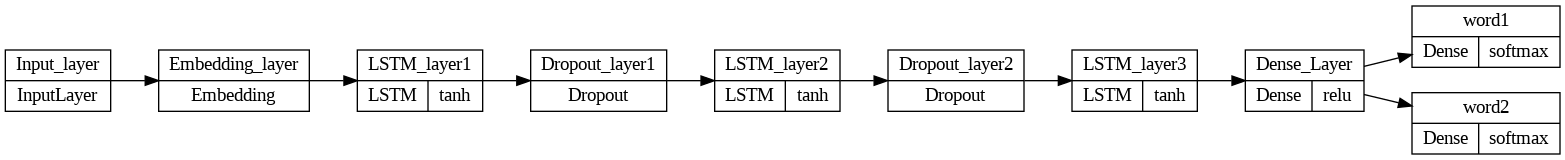

In [ ]:
plot_model(model_word, to_file = 'model_word_plot.png', 
           show_layer_names = True, show_layer_activations = True,
           rankdir = 'LR')

In [ ]:
model_word.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None, 18)]         0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, 18, 100)      315400      ['Input_layer[0][0]']            
                                                                                                  
 LSTM_layer1 (LSTM)             (None, 18, 200)      240800      ['Embedding_layer[0][0]']        
                                                                                                  
 Dropout_layer1 (Dropout)       (None, 18, 200)      0           ['LSTM_layer1[0][0]']            
                                                                                            

####**2.2 Model for character level prediction**

Character level model construction followed the same rationale of building the word-level one but with minor differences: 1) the output dimension is only 8, 2) it has only one dropout layer and two LSTM layers, 3) the units in each layer are reduced to 88, 4) output layers have a unit size of letter size, and finally, 5) the early stopping monitor is validation loss.

These changes are made because the computer only needs to learn the pattern of 26 letters, so it does not require a model as complex as the word level one.

In [ ]:
# Character level
# Input layer
input_layer = Input(shape=(None,), name='Input_layer')
# Hidden layers
embedding_layer = Embedding(input_dim=train_letter_size, output_dim=8, name='Embedding_layer')(input_layer)
lstm_layer1 = LSTM(88, return_sequences=True, name='LSTM_layer1')(embedding_layer)
dropout_layer1 = Dropout(0.5, name='Dropout_layer')(lstm_layer1)
lstm_layer2 = LSTM(88, name='LSTM_layer2')(dropout_layer1)
dense_layer = Dense(88, activation='relu', name='Dense_Layer')(lstm_layer2)
# Output layers
output_letter1 = Dense(train_letter_size, activation='softmax', name='letter1')(dense_layer)
output_letter2 = Dense(train_letter_size, activation='softmax', name='letter2')(dense_layer)

model_char = Model(inputs=input_layer, outputs=[output_letter1, output_letter2])

# Complie model
model_char.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=0.001))

# Early stopping
early_stopping_char = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

**Visualisation**

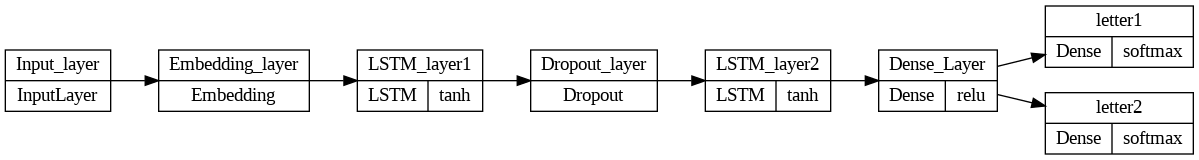

In [ ]:
plot_model(model_char, to_file = 'model_char_plot.png', 
           show_layer_names = True, show_layer_activations = True,
           rankdir = 'LR')

In [ ]:
model_char.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, None, 8)      216         ['Input_layer[0][0]']            
                                                                                                  
 LSTM_layer1 (LSTM)             (None, None, 88)     34144       ['Embedding_layer[0][0]']        
                                                                                                  
 Dropout_layer (Dropout)        (None, None, 88)     0           ['LSTM_layer1[0][0]']            
                                                                                            

### **Step 3: Model Training and Evaluation**

I set a validation set for all model training to increase the generalisability of the model.

####**3.1 Word Level**

In [ ]:
training_info_word = model_word.fit(Xtrain, [ytrain_word1, ytrain_word2], 
                                    epochs=50, batch_size=64, 
                                    validation_split=0.1, 
                                    callbacks=early_stopping_word)

Epoch 1/50
331/331 [==============================] - 209s 577ms/step - loss: 12.9661 - word1_loss: 6.4855 - word2_loss: 6.4806 - word1_accuracy: 0.0340 - word2_accuracy: 0.0347 - val_loss: 13.0068 - val_word1_loss: 6.4933 - val_word2_loss: 6.5135 - val_word1_accuracy: 0.0485 - val_word2_accuracy: 0.0345
Epoch 2/50
331/331 [==============================] - 189s 572ms/step - loss: 12.4710 - word1_loss: 6.2370 - word2_loss: 6.2340 - word1_accuracy: 0.0339 - word2_accuracy: 0.0338 - val_loss: 13.1593 - val_word1_loss: 6.5638 - val_word2_loss: 6.5955 - val_word1_accuracy: 0.0332 - val_word2_accuracy: 0.0345
Epoch 3/50
331/331 [==============================] - 192s 582ms/step - loss: 12.4199 - word1_loss: 6.1953 - word2_loss: 6.2246 - word1_accuracy: 0.0322 - word2_accuracy: 0.0350 - val_loss: 13.0715 - val_word1_loss: 6.4785 - val_word2_loss: 6.5930 - val_word1_accuracy: 0.0485 - val_word2_accuracy: 0.0549
Epoch 4/50
331/331 [==============================] - 185s 561ms/step - loss: 12.2

The word level model stopped training after completing the 20th epoch. In the training set, the lowest total loss was 10.06, and the highest first word and second word accuracies were 0.10 and 0.07, respectively. In the validation set, the lowest total loss was 13.01, and the highest first word and second word accuracies were 0.08 and 0.06, respectively.

Next, we checked the performance of the model on the test set.

**Model Evaluation on Test Set**

In [ ]:
# Evaluate the word-level model
word_model_total_loss, word_model_loss1, word_model_loss2, word_model_accuracy1, word_model_accuracy2 = model_word.evaluate(Xtest_word, [ytest_word1, ytest_word2])
print("Word-level model:")
print("Total Loss:", word_model_total_loss)
print("Loss (word 1):", word_model_loss1)
print("Loss (word 2):", word_model_loss2)
print("Accuracy (word 1):", word_model_accuracy1)
print("Accuracy (word 2):", word_model_accuracy2)

184/184 [==============================] - 28s 155ms/step - loss: 13.3918 - word1_loss: 6.4564 - word2_loss: 6.9355 - word1_accuracy: 0.0766 - word2_accuracy: 0.0593
Word-level model:
Total Loss: 13.391824722290039
Loss (word 1): 6.456358432769775
Loss (word 2): 6.935458660125732
Accuracy (word 1): 0.07662249356508255
Accuracy (word 2): 0.0592932365834713


The prediction accuracies in the test set were closer to those in validation set rather than training set, but the test accuracies were still the lowest.

**Visualising Model Performance**

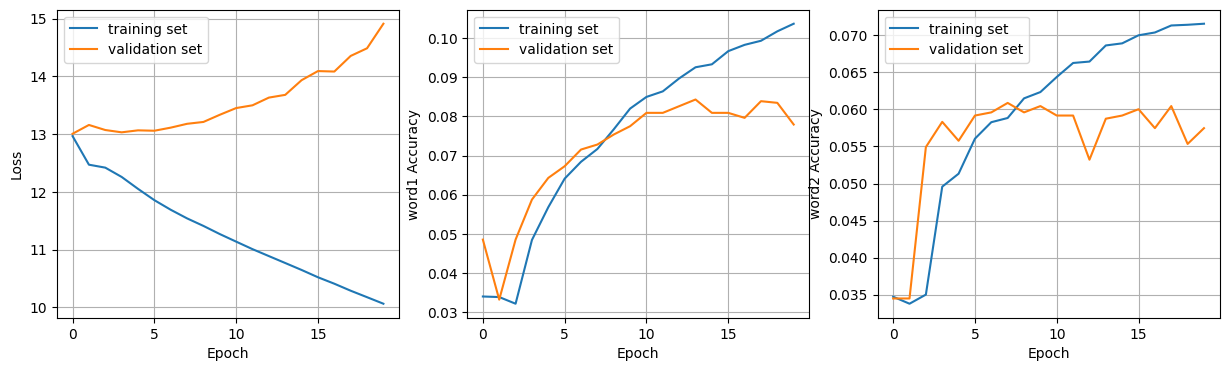

In [ ]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['word1_accuracy'], label="training set")
    axs[1].plot(training_info.history['val_word1_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("word1 Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(training_info.history['word2_accuracy'], label="training set")
    axs[2].plot(training_info.history['val_word2_accuracy'], label="validation set")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("word2 Accuracy")
    axs[2].grid(True)
    axs[2].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info_word)

The plot show that the loss of the training set kept decreasing while the loss of validation set started to increase since the fifth epoch. Both accuracies were increasing in the training set. However, in validation set, the first word accuracy raised to 0.08 and remained almost the same after the 10th epoch, while the second word accuracy fluctuated between 0.055 and 0.06 after the fourth epoch.

**Previous Attempts.** The plots below demonstrated the full training process (80 epochs). We can see that the loss of validation was always increasing despite a decrease in the training set, and the validation accuracies dropped after 20 epochs, indicating overfitting and poor generalisability.

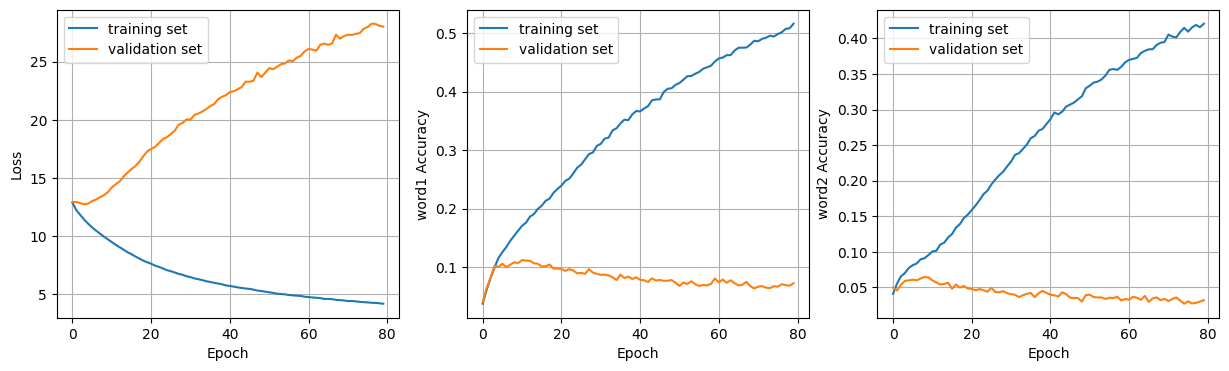

In [ ]:
# Previous training
plot_training_history(training_info_word)

**Discussion**

This multi-output LSTM model was built to predict the next two words given one or several words.

Overall, with the high loss rates and the low accuracies, the model of predicting the next two words did not perform well. By looking at the increasing validation loss and decreasing accuracy, we can conclude that the model was overfitting and had low generalisability even with two dropout layers.

Several possible reasons may contribute to this result. First, the computer needs to learn a large vocabulary size, but the data we provided might be insufficient. Thus, we may increase the accuracy by providing more training data without further addition of new vocabulary. Second, because we have a large vocabulary size, we might have insufficient layers and units. Adding more layers and units may allow the computer to learn more complex patterns. Lastly, the way we prepared the data might not be perfect. Segmenting text into 20 words per chunk might increase the training efficiency, but it might also break some patterns of natural sentences.

####**3.2 Character Level**

In [ ]:
training_info_char_dropout = model_char.fit(Xtrain_char, [ytrain_letter1, ytrain_letter2], 
                                    epochs=80, batch_size=64, 
                                    validation_split=0.1, 
                                    callbacks=early_stopping_char)

Epoch 1/80
916/916 [==============================] - 157s 166ms/step - loss: 5.3573 - letter1_loss: 2.5729 - letter2_loss: 2.7843 - letter1_accuracy: 0.1955 - letter2_accuracy: 0.1675 - val_loss: 4.8405 - val_letter1_loss: 2.2345 - val_letter2_loss: 2.6059 - val_letter1_accuracy: 0.2911 - val_letter2_accuracy: 0.2267
Epoch 2/80
916/916 [==============================] - 149s 163ms/step - loss: 4.8033 - letter1_loss: 2.2215 - letter2_loss: 2.5819 - letter1_accuracy: 0.2857 - letter2_accuracy: 0.2274 - val_loss: 4.5715 - val_letter1_loss: 2.1005 - val_letter2_loss: 2.4711 - val_letter1_accuracy: 0.3335 - val_letter2_accuracy: 0.2673
Epoch 3/80
916/916 [==============================] - 147s 160ms/step - loss: 4.5856 - letter1_loss: 2.1044 - letter2_loss: 2.4812 - letter1_accuracy: 0.3221 - letter2_accuracy: 0.2595 - val_loss: 4.3850 - val_letter1_loss: 2.0044 - val_letter2_loss: 2.3806 - val_letter1_accuracy: 0.3613 - val_letter2_accuracy: 0.2837
Epoch 4/80
916/916 [====================

The character level model stopped training after completing the 79th epoch. In the training set, the lowest total loss was 2.59, and the highest first letter and second letter accuracies were 0.61 and 0.53 respectively. In the validation set, the lowest total loss was 2.85, and the highest first letter and second letter accuracies were 0.60 and 0.53 respectively.

The result so far was acceptable, we should also check the performance of the model on the test set.

**Model Evaluation on Test Set**

In [ ]:
# Evaluate the character-level model
char_model_total_loss, char_model_loss1, char_model_loss2, char_model_accuracy1, char_model_accuracy2 = model_char.evaluate(Xtest_char, [ytest_letter1, ytest_letter2])
print("Character-level model:")
print("Total Loss:", char_model_total_loss)
print("Loss (letter 1):", char_model_loss1)
print("Loss (letter 2):", char_model_loss2)
print("Accuracy (letter 1):", char_model_accuracy1)
print("Accuracy (letter 2):", char_model_accuracy2)

503/503 [==============================] - 17s 33ms/step - loss: 2.9124 - letter1_loss: 1.2569 - letter2_loss: 1.6555 - letter1_accuracy: 0.5879 - letter2_accuracy: 0.5122
Character-level model:
Total Loss: 2.9123952388763428
Loss (letter 1): 1.2568925619125366
Loss (letter 2): 1.6554996967315674
Accuracy (letter 1): 0.5879063010215759
Accuracy (letter 2): 0.512211799621582


The accuracies of predicting the next two words are only 0.02 lower than the accuracies in training and validation sets, indicating that the model has good generalisability on test set.

**Visualising Model Performance**

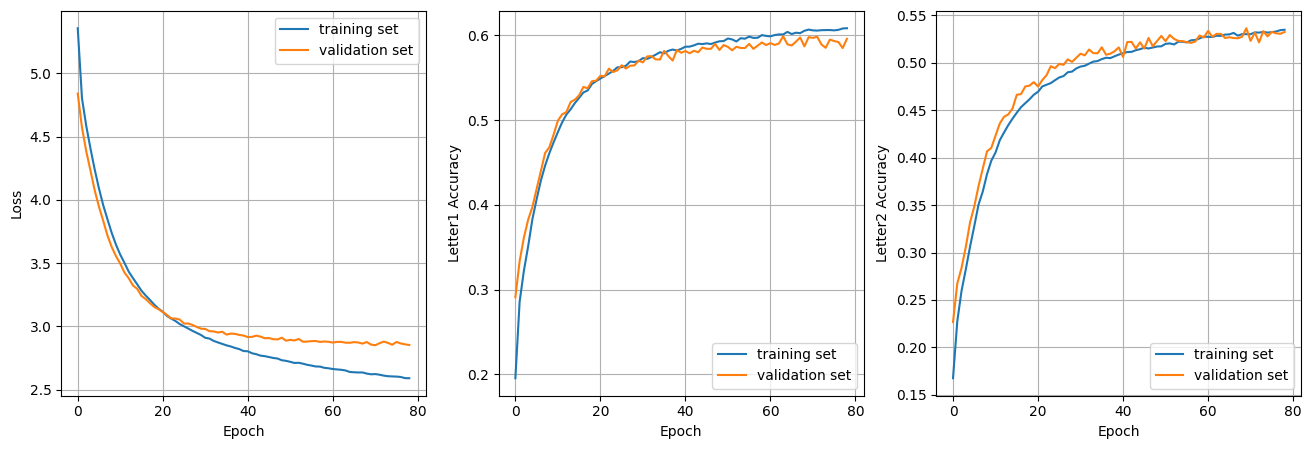

In [ ]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 3, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['letter1_accuracy'], label="training set")
    axs[1].plot(training_info.history['val_letter1_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Letter1 Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(training_info.history['letter2_accuracy'], label="training set")
    axs[2].plot(training_info.history['val_letter2_accuracy'], label="validation set")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Letter2 Accuracy")
    axs[2].grid(True)
    axs[2].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info_char_dropout)

The plots demonstrate that the loss of both training and validation sets decreased rapidly in the first 20 epochs. After the 50th epoch, the loss of training set kept decreasing while that of validation set remained almost the same. All accuracies increased rapidly in the first 20 epochs and started to increase slowly after. The validation set almost shared the same accuracy as the training set, indicating the good generalisability of this model.

**Previous Attempts.** The plots below demonstrated one of the previous attempts with two dropout layers. In this attempt, the loss of validation set was always lower than that of training set, and the accuracies of validation set were always higher than those of training set.

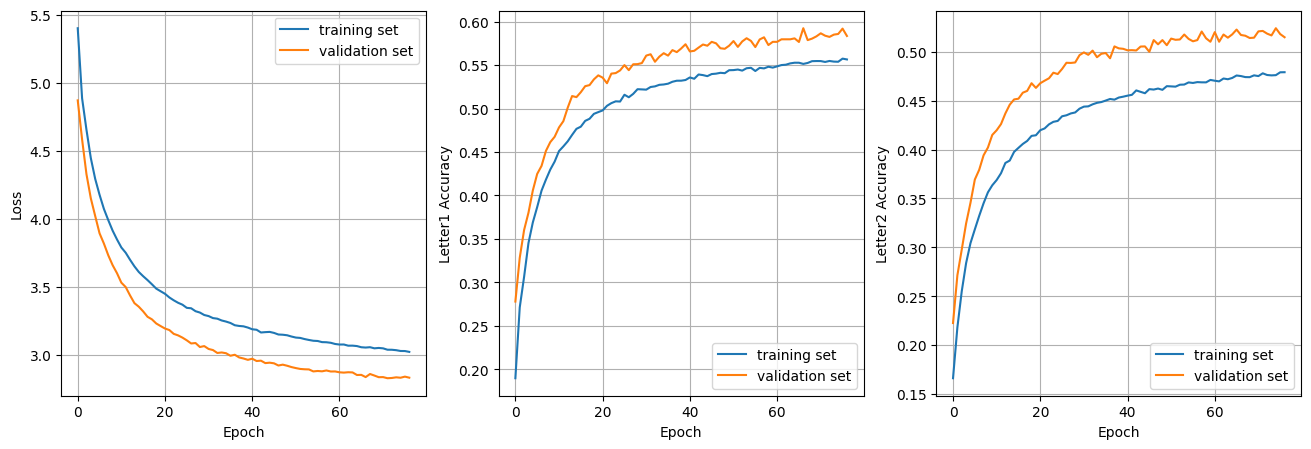

In [ ]:
# Previous attempt 1
plot_training_history(training_info_char)

I also tried training the data without a dropout layer (see plots below). The model became overfitting without a dropout layer.

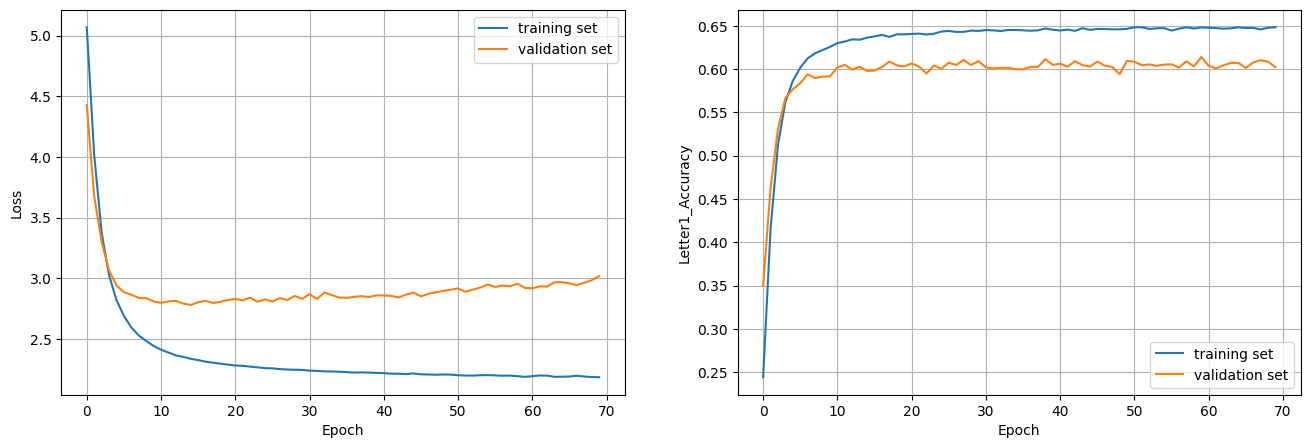

In [ ]:
# Previous attempt 2
plot_training_history(training_info_char)

**Discussion**

This multi-output LSTM model was built to predict the next two letters given one or several letters.

Overall, the model for letter prediction has a satisfying result. The prediction accuracy is not incredibly high but is a good one for predicting one of the 26 letters. The present model also has good generalisability, because the accuracies in training, validation, and test sets are very similar. By comparing the training results with two dropout layers, one dropout layer, and without any dropout layer, my results also emphasise the importance of the dropout layer in increasing the generalisability of this model.

To further increase the prediction accuracy of the model, I proposed several approaches. First, increasing the number of data may help the computer learn the pattern because the letter size will not further increase. Second, since the data I prepared only allowed the computer to learn word by word, the model may not be able to make predictions based on the previous words. Thus, we may put several words into a chunk, so that the model will also learn from the previous words.

## **Part C: General Discussion**

Since letter prediction is less complex, using normal RNNs instead of LSTMs may also achieve a good result with fewer computational resources needed. On the other hand, word prediction is much more complicated, a more advanced model may perform better than the current one. For example, using Bidirectional Encoder Representations from Transformers (BERT). BERT is based on the Transformer architecture and uses self-attention mechanisms to process input sequences (Devlin et al., 2018). Since BERT is bidirectional, it can capture both left and right context when predicting the next word. This is why it can lead to better performance compared to the present model, which is unidirectional. However, BERT can be computationally expensive because it has a large number of parameters. Thus, implementing LSTMs is more achievable when the computational resources are limited.

**Conclusion**

The present work used RNNs with LSTMs to build two models, with one of them predicting the next two words and the other predicting the next two letters given incomplete sentences or words. The model predicting words did not perform well, considering a large vocabulary size that could be difficult to capture the pattern. However, the model predicting letters performed relatively better and had good generalisability. The predictive accuracy might be further improved by providing more data or changing the data pre-processing approach. Current work also found the effect of adding dropout layers on the model generalisability. 

**References**

Austen, J. (2022, November 12). *Pride and prejudice*. The Project Gutenberg. https://www.gutenberg.org/cache/epub/1342/pg1342.txt

Chen, S. F., & Goodman, J. (1999). An empirical study of smoothing techniques for language modeling. *Computer Speech & Language, 13*(4), 359-394.

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. *arXiv preprint arXiv:1810.04805.*

Fchollet (2019, March 1). *The Functional API*. Keras. https://keras.io/guides/functional_api/.

Ganai, A. F., & Khursheed, F. (2019, November). Predicting next word using RNN and LSTM cells: Stastical language modeling. In *2019 Fifth International Conference on Image Information Processing (ICIIP)* (pp. 469-474). IEEE.

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural computation, 9*(8), 1735-1780.

Medsker, L. R., & Jain, L. C. (2001). Recurrent neural networks. *Design and Applications, 5*, 64-67.